# Word2Vec

A demonstation of the main word2vec alorithms.

In this notebook I take a corpus of text, such as shakespeare, and embed all the words found there into a lower dimentional space. I then look at how these worsds are releated to each other. This project can use the same input as the LSTM model, so does not need a seperate data-prep notebook.

Take the shakespeare text and pass it through the tokenizer. We should ignore some of the most rare words, as this will make our task impossible.

We then convert our text to tokens, this is simply a list of numbers in place of our text.

Make sure that we have dictionaries that do both conversions of numbers to words and words to numbers.

Run this through the skip-gram model, this gives us pairs of words, context and focal word, as well as binary are a pair not a pair. Remeber to construct the lookup table for the words, this may be important.

Now build the model. Use the funcitonal API for this as there are some complexities here.

Once we have trained the model contruct the idea of A is to B as C is to what ... and test it with a few obvious things, such as the characters in the play etc.

Take a list of words and look at their nearest neighbours. This should make some sense intuatively.

Build an overall 2D representation of the words. This should show words that seem related close to each other.

In [1]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, merge, Reshape
from keras.activations import sigmoid
from collections import Counter
import string
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### Parameters

These are the main things to play with in the model. There are other things you could potentially tweak of course.

In [2]:
# Words must appear atleast this many times in the corpus to be counted
threshold = 25
# How many words either side to include as context. As small as one can word
# larger windows take longer to train, but might give a more neuanced approach
# A very large window might begin to break down. I suggest trying one to begin
# with, and then moving no higher than 5.
window_size = 1
# Dimentionality of the embedding space. 300 is quite typical, but the examples
# I've seen often use a bigger corpus, so maybe smaller than that might be appropriate
emb_dim = 128

Things to play around with:
* Does training it over more epochs really help
* Try other variations of the model, such as using the one-hot encodings, window word must predict the focus word, this takes longer to train, and some people have claimed that the trick I am using is actually almost as good as the much longer model, but could be interesting to see if this were the case.
* Try the GLoVe model, a variation on this.
* Split the words into sentences. Only words in the same sentence matter. A word being next to another word, but seperated by a full-stop are not necessarily related.
* Mess around with the window size, how does this effect the results.
* Make the embeddin dimention smaller. Does this lead to quicker training? (should do) but still give similiar quality results.
* Try the CBOW model. In this one we sum the one-hot representations of all window words and use these to try to predict the focal word.
* What is the effect of removing known positive samples from the list of known negative samples.

## Preprocessing

Load the data into a single string, should be small enough to fit into memory.

In [3]:
file_name = '../data/text/simpleshake.txt'
with open(file_name, 'rt') as f:
    text = f.read()

And tokenize the words. This is a way of replacing every word with an integer, such that the most common word becomes 1 and the next 2 etc. until a prespecified number of words. Very rare words will be replaced by a special token such as None or 0.

I'm having some trouble with the keras tokenizer, so I'll write some logic myself. This should be straight-forward.

In [4]:
text = text.replace('.', ' ').replace(',', ' ')

In [5]:
word_counts = Counter(text.split())

In [6]:
len(word_counts)

30410

Let's get rid of rare words, this is defined as a threshould that a word must appear more than to be included.

In [7]:
word_counts_cut = [k for k in word_counts if word_counts[k] > threshold]

In [8]:
vocab_size = len(word_counts_cut)
print("Total words: {}".format(vocab_size))

Total words: 3082


And sort the cut words now, from most common to most rare.

In [9]:
sorted_words = sorted(word_counts_cut, key=lambda x: word_counts[x], reverse=True)

Now make the mappings.

In [10]:
word2num = {k:i for i,k in enumerate(sorted_words)}
num2word = {i:k for i,k in enumerate(sorted_words)}

Now we apply our mapping to the origonal text, replacing each word with a number, or None, if it is a rare word.

In [11]:
int_seq = []
for w in text.split():
    try:
        int_seq.append(word2num[w])
    except KeyError:
        int_seq.append(None)
        

## Prepare the skip-gram

Use the keras skip gram model to look get pairs of words. These should be the a focal word, and a word in the window. If None is in the list then ignore the item, as this is a rare word. Simply stripping None from the vocab would result in words that may not actually be next to each other being in the list of positives.

Let's also do this by hand, as the skipgram function seems to be doing weird things.

Make a list of all positive samples.

In [12]:
positive_samples = []

In [13]:
for w in range(1, window_size+1):
    # Examples which are w behind the focal word, where w goes from one upto the window
    # size.
    positive_samples += [(int_seq[i], int_seq[i - w]) for i in range(w, len(int_seq))]
    # And those that aer n places ahead of the focal word
    positive_samples += [(int_seq[i], int_seq[i + w]) for i in range(len(int_seq) - w)]

And remove those that have a None in them.

In [14]:
positive_samples = [p for p in positive_samples if None not in p]
ps_set = set(positive_samples)

And we can generate some random negative samples as well. I'll generate pairs at random, but get rid of those that are actually positive samples. The two classes don't need to be exactly the same size, but roughly is good, which is why I initially generate a few more samples than I actually need, as I will remove some later.

In [15]:
neg_size = int(len(positive_samples)*1.08)

In [16]:
negative_samples = [(np.random.randint(vocab_size), np.random.randint(vocab_size)) for _ in range(neg_size)]

Now remove those negative samples that are actually positive samples by coincidence.

In [17]:
negative_samples = [n for n in negative_samples if n not in ps_set]

Create an array of labels, this is just zero and one repeated.

In [18]:
labels = [1]*len(positive_samples) + [0]*len(negative_samples)

In [19]:
data = positive_samples + negative_samples

In [20]:
data = np.array(data)
labels = np.array(labels)

In [21]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1)

In [22]:
x_train = train_data[:,0]
y_train = train_data[:,1]
x_test = test_data[:,0]
y_test = test_data[:,1]

## Build the model

We have the data and the labels as normal now, so let's see how our model does at predicting them.

In [23]:
focus = Input(shape=(1,), name='focus')
context = Input(shape=(1,), name='context')
emb = Embedding(input_dim=vocab_size, output_dim=emb_dim)
hid1 = emb(focus)
hid2 = emb(context)
final = merge([hid1, hid2], mode='dot', dot_axes=2)
# the reshape just gets rid of one of the list nestings, as this will confilct
# with the labels
output = Reshape((1,))(Dense(1, activation='sigmoid')(final))

model = Model(input=[focus, context], output=output)

/Users/simontudge/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:6: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/simontudge/anaconda/lib/python3.4/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/simontudge/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("re...)`


Now compile and train the model.

In [24]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [25]:
model.fit([x_train, y_train], train_labels, epochs=5)

Epoch 1/5
2805223/2805223 [==============================] - 369s 131us/step - loss: 0.2957 - acc: 0.8947
Epoch 2/5
2805223/2805223 [==============================] - 367s 131us/step - loss: 0.2823 - acc: 0.9046
Epoch 3/5
2805223/2805223 [==============================] - 386s 138us/step - loss: 0.3466 - acc: 0.8896
Epoch 4/5
2805223/2805223 [==============================] - 416s 148us/step - loss: 0.4436 - acc: 0.8796
Epoch 5/5
2805223/2805223 [==============================] - 407s 145us/step - loss: 0.5465 - acc: 0.8753


In [26]:
_, ac = model.evaluate([x_test, y_test], test_labels)

311692/311692 [==============================] - 6s 21us/step


In [27]:
print("Accuracy: {}".format(ac))

Accuracy: 0.906276067400634


## Inspect the model

Now that we have a trained model, let's see what we can do with it.

* Look at top matching words, e.g. which 8 words are most like 'the' or 'hamlet'
* Word vectors: Offilia is to hamlet as Juliet is to.... etc.
* Plane visualistation of all the different words

Use the trick mentioned in this [blog post]() which says that we can use keras to find the similiarity between two layers using another model.

In [28]:
sim = Reshape((1,))(merge([hid1, hid2], mode='cos', dot_axes=2))
model2 = Model(inputs=[focus, context], output=sim)

/Users/simontudge/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:1: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if __name__ == '__main__':
/Users/simontudge/anaconda/lib/python3.4/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/simontudge/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("re...)`
  from ipykernel import kernelapp as app


In [29]:
def nearest_words(word, n=8):
    """
    Returns the n nearest words to the vector given.
    """
    
    # Look up the integer of this word
    Int = word2num[word]
    # Compute all distances
    x = np.array([Int]*vocab_size)
    y = np.array(range(vocab_size))
    
    distances = model2.predict([x,y]).flatten()
    top_matches = list(distances.argsort()[-n-1:-1])
    top_matches.reverse()
    
    # And decode these to actual words
    return [num2word[i] for i in top_matches]

Key words. Fairly arbitrary list of key words to look at, including the most common words and a few I chose myself.

In [30]:
lookup_words = sorted_words[:5] + ['hamlet', 'cleopatra'] +['one', 'two'] + list(np.random.choice(sorted_words, 6))

In [31]:
for word in lookup_words:
    print(word)
    print(nearest_words(word))

the
['a', 'my', 'your', 'his', 'thy', 'this', 'our', 'an']
and
['but', 'or', 'than', 'nor', 'which', 'why', 'enter', 'o']
i
['we', 'thou', 'they', 'he', 'she', 'you', 'ill', 'exit']
to
['in', 'with', 'at', 'of', 'by', 'from', 'o', 'on']
of
['with', 'at', 'from', 'for', 'o', 'in', 'by', 'upon']
hamlet
['timon', 'othello', 'macbeth', 'hastings', 'capulet', 'chamberlain', 'angelo', 'gracious']
cleopatra
['bolingbroke', 'silvia', 'englands', 'falln', 'olivia', 'yourselves', 'pericles', 'juliet']
one
['it', 'her', 'them', 'these', 'their', 'mine', 'our', 'us']
two
['still', 'down', 'peace', 'blood', 'both', 'lords', 'three', 'death']
worship
['army', 'cheek', 'knees', 'bones', 'woes', 'beard', 'curse', 'whore']
cares
['ends', 'persons', 'knocks', 'slept', 'breaks', 'friendly', 'shines', 'creatures']
trees
['imagination', 'bohemia', 'lifes', 'human', 'choler', 'suits', 'semblance', 'running']
touching
['nest', 'pearl', 'youthful', 'manly', 'lodging', 'beauteous', 'tall', 'willow']
keeper
['m

Now do some vector additions.

Get the vector for a given word.

In [32]:
embedding = Model(input=focus, output=hid1)
def get_vec(word):
    Int = word2num[word]
    out = embedding.predict(np.array([Int]))
    return out[0]

/Users/simontudge/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("fo..., outputs=Tensor("em...)`
  if __name__ == '__main__':


Should this be romeo?

Define yet another model in order to get the nearest vector to another vector.

In [33]:
in_vec = Input((1,emb_dim,), name='in_v')
y = Input((1,), name='in_int')
emby = emb(y)
closeness = Reshape((1,))(merge([in_vec, emby], mode='cos', dot_axes=2))
nearest_vec_model = Model(inputs=[in_vec, y], outputs=closeness)


/Users/simontudge/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:4: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/simontudge/anaconda/lib/python3.4/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [48]:
def nearest_to_vec(vec):
    """
    Finds the word that is nearest to the input vector.
    """
    x = np.array(list([vec])*vocab_size)
    print(x.shape)
    y = np.array(range(vocab_size))
    distances = nearest_vec_model.predict([x,y])
    return num2word[distances.argmin()]

i - me = we - us

In [57]:
nearest_to_vec(get_vec('i') - get_vec('me') - get_vec('we'))

(3082, 1, 128)


'him'

In [50]:
nearest_to_vec(get_vec('ophelia') - get_vec('hamlet') + get_vec('romeo'))

(3082, 1, 128)


'exit'

In [51]:
nearest_to_vec(get_vec('hate') - get_vec('love') + get_vec('happy'))

(3082, 1, 128)


'whose'

Plotting of the embedding...

After a little experimentation it looks like this approach does not really work in this case! I wonder why that is!

In [38]:
from sklearn.manifold import TSNE

We need to instantiate this class we some parameters, then pass a list of the embeddings to the class. We can then plot the output and annotate with the list of words.

In [39]:
embedding_matrix = emb.get_weights()[0]

In [40]:
tsne = TSNE(init='pca')
projections = tsne.fit_transform(embedding_matrix)

In [41]:
import matplotlib.pyplot as plt

%matplotlib inline

(90, 96)

/Users/simontudge/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


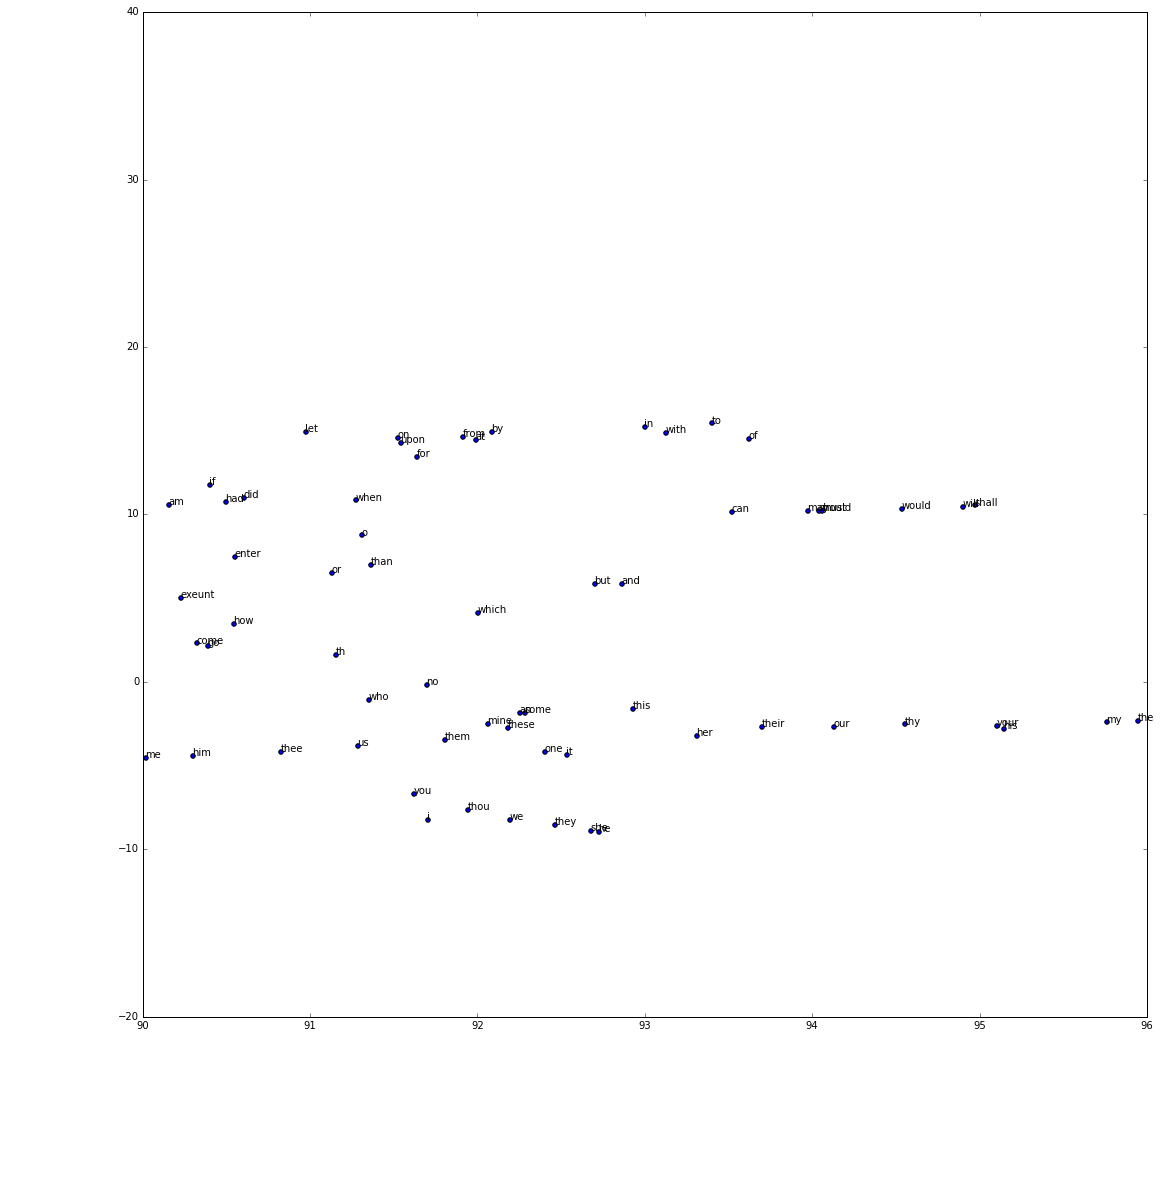

In [44]:
_, ax = plt.subplots(figsize=(18,18))
for point, word in zip(projections[:150], sorted_words[:150]):
    ax.scatter(*point)
    ax.annotate(word, point)
ax.set_xlim(90,96)